In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import neural_tangents as nt

from neural_tangents import stax
import flax.linen as nn
from typing import Sequence
from jax import jit
from jax import random

from src.kernels.reference_kernels import ARDKernel, NeuralNetworkGaussianProcessKernel
from src.kernels.approximation_kernels import StochasticVariationalGaussianProcessKernel
from src.mean_functions.reference_mean_functions import ConstantFunction
from src.mean_functions.approximation_mean_functions import (
    StochasticVariationalGaussianProcessMeanFunction,
    NeuralNetworkMeanFunction,
)
from src.gaussian_measures import ReferenceGaussianMeasure, ApproximationGaussianMeasure

In [2]:
SEED = 0
np.random.seed(SEED)
key = random.PRNGKey(SEED)
number_of_data_points = 100
training_data_percentage = 0.9
number_of_training_data_points = jnp.ceil(
    training_data_percentage * number_of_data_points
)
sigma_true = 0.5

x = jnp.linspace(-2, 2, number_of_data_points, dtype=np.float32).reshape(-1)

key, subkey = random.split(key)


def calculate_y(x):
    return (
        2 * jnp.sin(x * (jnp.pi)) + sigma_true * random.normal(subkey, shape=x.shape)
    ).reshape(-1)

In [3]:
train_ranges = [(-2, -1), (0, 2)]
test_ranges = [(-1, 0)]
x_train = []
y_train = []
for train_range in train_ranges:
    x_train.extend(x[(train_range[0] <= x) & (x <= train_range[1])])

x_test = []
y_test = []
for test_range in test_ranges:
    x_test.extend(x[(test_range[0] <= x) & (x <= test_range[1])])
x = x.reshape(-1, 1)
x_train = jnp.array(x_train).reshape(-1, 1)
x_test = jnp.array(x_test).reshape(-1, 1)
y_train = calculate_y(x_train)
y_test = calculate_y(x_test)

In [4]:
number_of_inducing_points = int(0.5 * np.sqrt(number_of_data_points))
key, subkey = random.split(key)
inducing_indices = random.choice(
    key,
    a=jnp.arange(number_of_training_data_points).astype(int),
    shape=(number_of_inducing_points,),
    replace=False,
)
x_inducing, y_inducing = x_train[inducing_indices], y_train[inducing_indices]

# Reference Measures

## ARD kernel

In [5]:
ard_gaussian_measure = ReferenceGaussianMeasure(
    x=x_inducing,
    y=y_inducing,
    kernel=ARDKernel(),
    mean_function=ConstantFunction(),
)
ard_gaussian_measure_parameters = ard_gaussian_measure.initialise_parameters(
    **{
        "log_observation_noise": jnp.log(2.0),
        "mean_function": {"constant": 0},
        "kernel": {
            "log_scaling": jnp.log(25.0),
            "log_lengthscales": jnp.log(1.0),
        },
    }
)
mean, covariance = ard_gaussian_measure.mean_and_covariance(
    x, ard_gaussian_measure_parameters
)

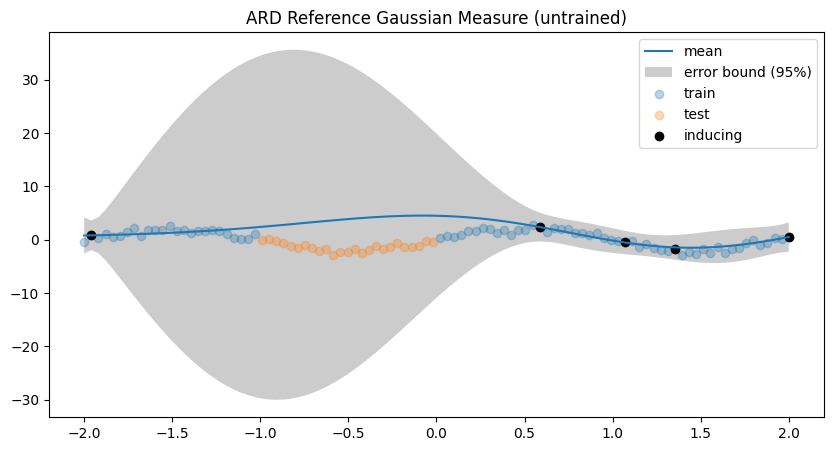

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("ARD Reference Gaussian Measure (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

## NNGP Kernel

In [7]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(10, W_std=5, b_std=5),
    stax.Erf(),
    stax.Dense(1, W_std=50, b_std=20),
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames="get")

In [8]:
nngp_gaussian_measure = ReferenceGaussianMeasure(
    x=x_inducing,
    y=y_inducing,
    kernel=NeuralNetworkGaussianProcessKernel(kernel_fn),
    mean_function=ConstantFunction(),
)
nngp_gaussian_measure_parameters = nngp_gaussian_measure.initialise_parameters(
    **{
        "log_observation_noise": jnp.log(10.0),
        "mean_function": {"constant": 0},
        "kernel": {},
    }
)
mean, covariance = nngp_gaussian_measure.mean_and_covariance(
    x, nngp_gaussian_measure_parameters
)

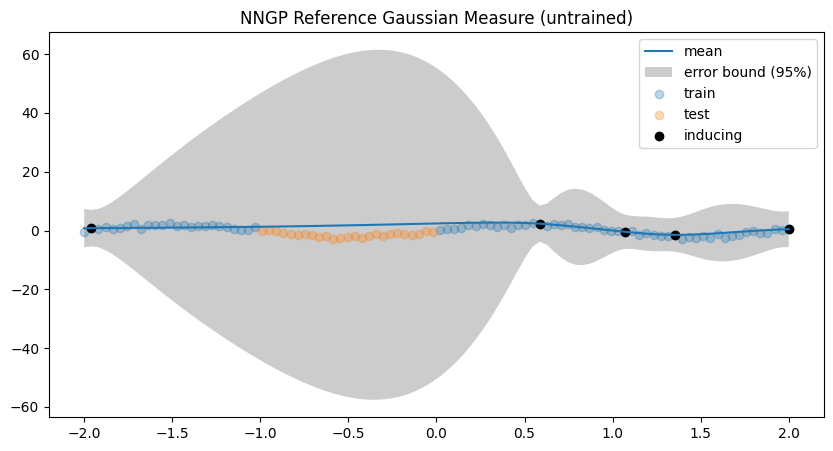

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("NNGP Reference Gaussian Measure (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

# Approximation Measures

## SVGP

### ARD Kernel

In [10]:
ard_approximation_gaussian_measure = ApproximationGaussianMeasure(
    x=x_train,
    y=y_train,
    kernel=StochasticVariationalGaussianProcessKernel(
        reference_gaussian_measure_parameters=ard_gaussian_measure_parameters,
        reference_kernel=ard_gaussian_measure.kernel,
        inducing_points=ard_gaussian_measure.x,
        training_points=x_train,
    ),
    mean_function=StochasticVariationalGaussianProcessMeanFunction(
        reference_gaussian_measure_parameters=ard_gaussian_measure_parameters,
        reference_mean_function=ard_gaussian_measure.mean_function,
        reference_kernel=ard_gaussian_measure.kernel,
        inducing_points=ard_gaussian_measure.x,
    ),
)

In [11]:
key, subkey = random.split(key)
ard_approximation_gaussian_measure_parameters = ard_approximation_gaussian_measure.initialise_parameters(
    **{
        "mean_function": ard_approximation_gaussian_measure.mean_function.initialise_random_parameters(
            subkey
        ),
        "kernel": {},
    }
)
mean, covariance = ard_approximation_gaussian_measure.mean_and_covariance(
    x, ard_approximation_gaussian_measure_parameters
)

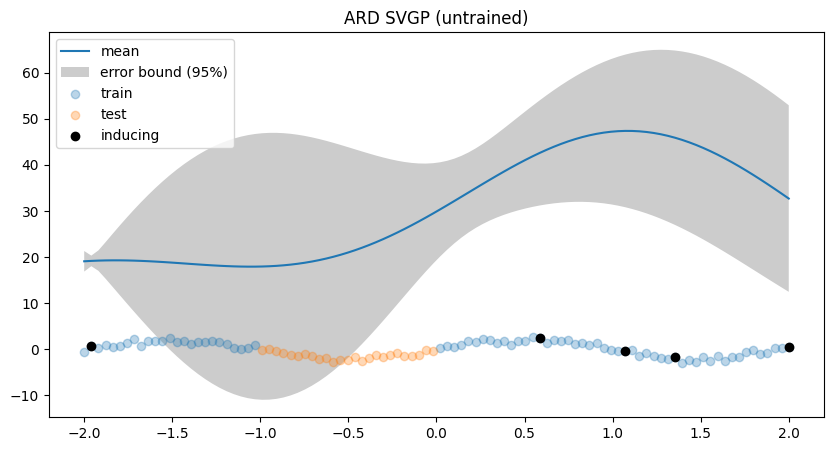

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("ARD SVGP (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

### NNGP Kernel

In [13]:
class MultiLayerPerceptron(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.tanh(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x.reshape(
            -1,
        )

In [14]:
neural_network = MultiLayerPerceptron([1, 10, 10, 1])
key, subkey = random.split(key)
neural_network_parameters = neural_network.init(subkey, x_train)

In [15]:
nngp_approximation_gaussian_measure = ApproximationGaussianMeasure(
    x=x_train,
    y=y_train,
    kernel=StochasticVariationalGaussianProcessKernel(
        reference_gaussian_measure_parameters=nngp_gaussian_measure_parameters,
        reference_kernel=nngp_gaussian_measure.kernel,
        inducing_points=nngp_gaussian_measure.x,
        training_points=x_train,
    ),
    mean_function=StochasticVariationalGaussianProcessMeanFunction(
        reference_gaussian_measure_parameters=nngp_gaussian_measure_parameters,
        reference_mean_function=ard_gaussian_measure.mean_function,
        reference_kernel=nngp_gaussian_measure.kernel,
        inducing_points=nngp_gaussian_measure.x,
    ),
)

In [16]:
key, subkey = random.split(key)
nngp_approximation_gaussian_measure_parameters = nngp_approximation_gaussian_measure.initialise_parameters(
    **{
        "mean_function": nngp_approximation_gaussian_measure.mean_function.initialise_random_parameters(
            subkey
        ),
        "kernel": {},
    }
)
mean, covariance = nngp_approximation_gaussian_measure.mean_and_covariance(
    x, nngp_approximation_gaussian_measure_parameters
)

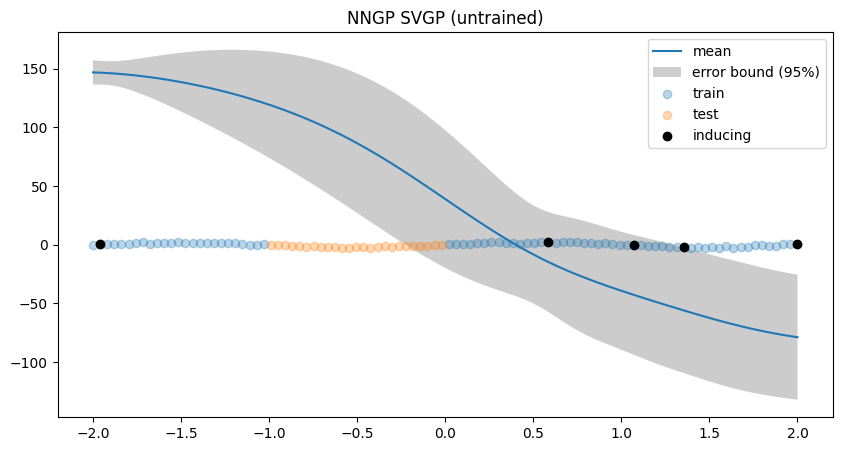

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("NNGP SVGP (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

## DNN SVGP

In [18]:
class MultiLayerPerceptron(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.tanh(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x.reshape(
            -1,
        )

In [19]:
neural_network = MultiLayerPerceptron([1, 10, 10, 1])
key, subkey = random.split(key)
neural_network_parameters = neural_network.init(subkey, x_train)

### ARD Kernel

In [20]:
ard_approximation_gaussian_measure = ApproximationGaussianMeasure(
    x=x_train,
    y=y_train,
    kernel=StochasticVariationalGaussianProcessKernel(
        reference_gaussian_measure_parameters=ard_gaussian_measure_parameters,
        reference_kernel=ard_gaussian_measure.kernel,
        inducing_points=ard_gaussian_measure.x,
        training_points=x_train,
    ),
    mean_function=NeuralNetworkMeanFunction(
        reference_gaussian_measure_parameters=ard_gaussian_measure_parameters,
        reference_mean_function=ard_gaussian_measure.mean_function,
        neural_network=neural_network,
    ),
)

In [21]:
key, subkey = random.split(key)
ard_approximation_gaussian_measure_parameters = (
    ard_approximation_gaussian_measure.initialise_parameters(
        **{
            "mean_function": neural_network_parameters,
            "kernel": {},
        }
    )
)
mean, covariance = ard_approximation_gaussian_measure.mean_and_covariance(
    x, ard_approximation_gaussian_measure_parameters
)

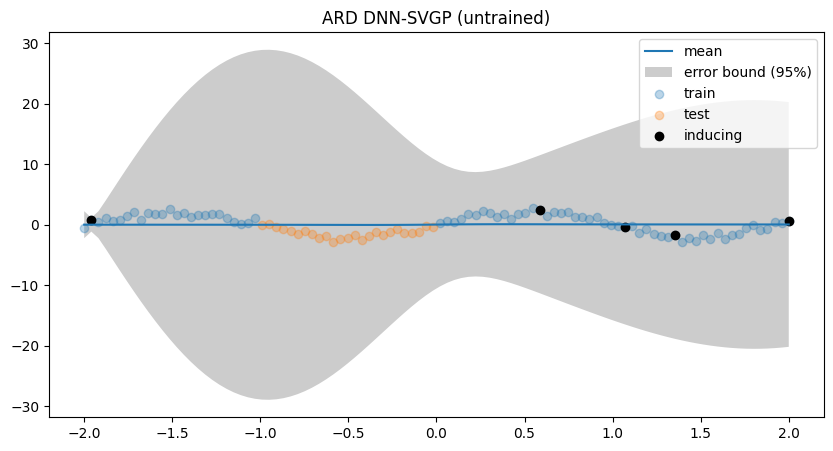

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("ARD DNN-SVGP (untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()

### NNGP Kernel 

In [23]:
nngp_approximation_gaussian_measure = ApproximationGaussianMeasure(
    x=x_train,
    y=y_train,
    kernel=StochasticVariationalGaussianProcessKernel(
        reference_gaussian_measure_parameters=nngp_gaussian_measure_parameters,
        reference_kernel=nngp_gaussian_measure.kernel,
        inducing_points=nngp_gaussian_measure.x,
        training_points=x_train,
    ),
    mean_function=NeuralNetworkMeanFunction(
        reference_gaussian_measure_parameters=nngp_gaussian_measure_parameters,
        reference_mean_function=nngp_gaussian_measure.mean_function,
        neural_network=neural_network,
    ),
)

In [24]:
key, subkey = random.split(key)
nngp_approximation_gaussian_measure_parameters = (
    nngp_approximation_gaussian_measure.initialise_parameters(
        **{
            "mean_function": neural_network_parameters,
            "kernel": {},
        }
    )
)
mean, covariance = nngp_approximation_gaussian_measure.mean_and_covariance(
    x, nngp_approximation_gaussian_measure_parameters
)

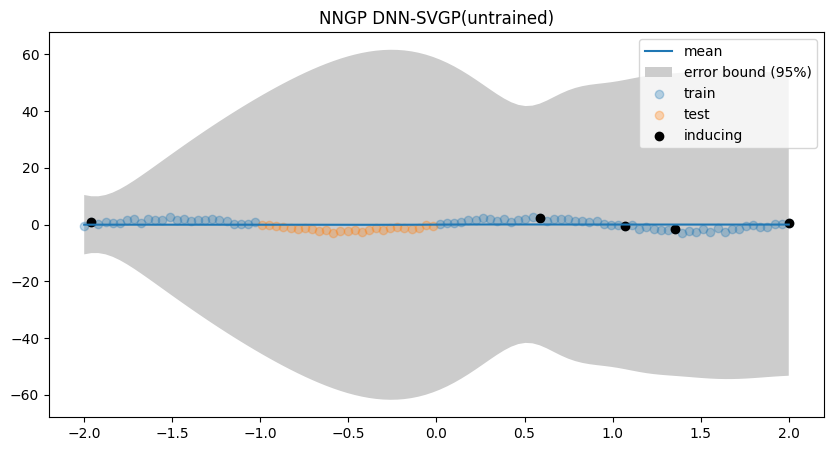

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(x.reshape(-1), mean, label="mean")
stdev = np.sqrt(np.diag(covariance))
plt.fill_between(
    x.reshape(-1),
    (mean - 1.96 * stdev).reshape(-1),
    (mean + 1.96 * stdev).reshape(-1),
    facecolor=(0.8, 0.8, 0.8),
    label="error bound (95%)",
)
plt.title("NNGP DNN-SVGP(untrained)")
plt.scatter(x_train, y_train, label="train", alpha=0.3)
plt.scatter(x_test, y_test, label="test", alpha=0.3)
plt.scatter(x_inducing, y_inducing, label="inducing", color="black")
plt.legend()
plt.show()